C:\Users\ITPARK\AppData\Local\Temp\ipykernel_7892\1447549477.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="Category", order=df["Category"].value_counts().index, palette="viridis", ax=axes[0])
C:\Users\ITPARK\AppData\Local\Temp\ipykernel_7892\1447549477.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=services, y=service_counts, palette="magma", ax=axes[1])
C:\Users\ITPARK\AppData\Local\Temp\ipykernel_7892\1447549477.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_by_category.values, y=rating_by_cat

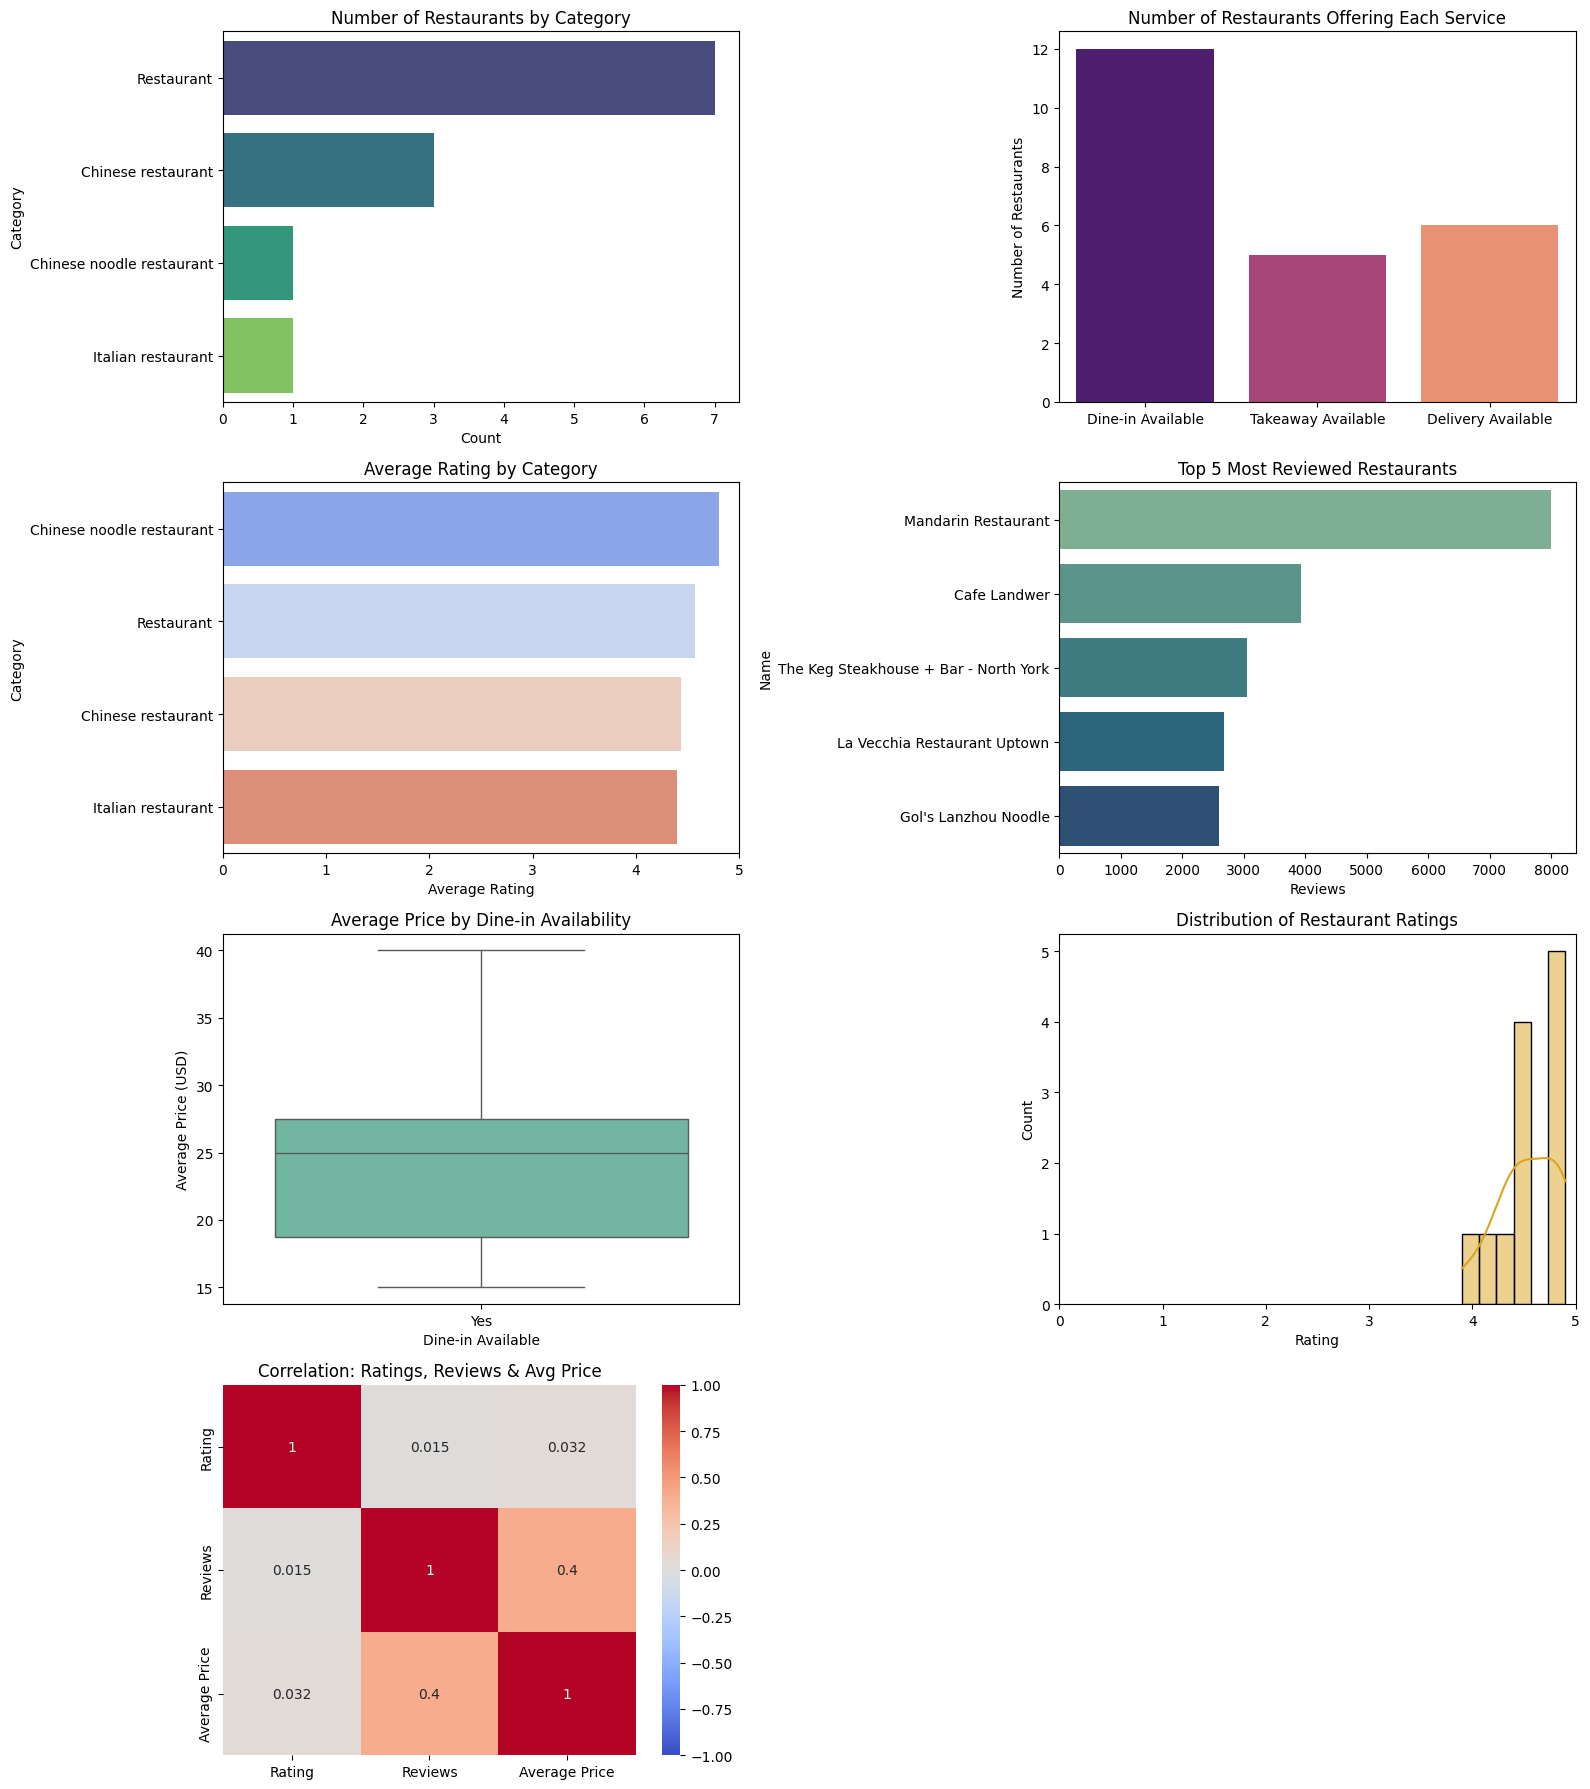

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def scrape_restaurants_data(urls):
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    data = []

    for url in urls:
        driver.get(url)
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "h1.DUwDvf.lfPIob"))
            )
        except:
            continue

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        name_element = soup.find("h1", class_="DUwDvf lfPIob")
        name_value = name_element.get_text(strip=True) if name_element else ""

        rating_value = ""
        reviews_value = ""
        container = soup.find("div", class_="F7nice")
        if container:
            rating_span = container.find("span", attrs={"aria-hidden": "true"})
            if rating_span:
                rating_value = rating_span.get_text(strip=True)

            reviews_span = container.find("span", attrs={"aria-label": lambda x: x and "reviews" in x})
            if reviews_span:
                reviews_text = reviews_span.get_text(strip=True)
                reviews_value = reviews_text.strip("()").replace(",", "")

        price_value = ""
        price_container = soup.find("span", class_="mgr77e")
        if price_container:
            price_span = price_container.find("span")
            if price_span:
                price_value = price_span.get_text(strip=True)

        category_value = ""
        category_button = soup.find("button", class_="DkEaL")
        if category_button:
            category_value = category_button.get_text(strip=True)

        address_value = ""
        address_container = soup.find("div", class_="rogA2c")
        if address_container:
            address_span = address_container.find("div", class_="Io6YTe")
            if address_span:
                address_value = address_span.get_text(strip=True)

        description_container = soup.find("div", class_="PYvSYb")
        description_value = description_container.get_text(strip=True) if description_container else ""

        dinein_available = "Yes" if soup.find("div", class_="LTs0Rc", attrs={"aria-label": lambda x: x and "Serves dine-in" in x}) else "No"
        takeaway_available = "Yes" if soup.find("div", class_="LTs0Rc", attrs={"aria-label": lambda x: x and "Offers takeaway" in x}) else "No"
        delivery_available = "Yes" if soup.find("div", class_="LTs0Rc", attrs={"aria-label": lambda x: x and "Offers delivery" in x}) else "No"

        data.append({
            "Name": name_value,
            "Rating": rating_value,
            "Reviews": reviews_value,
            "Price Range": price_value,
            "Category": category_value,
            "Address": address_value,
            "Description": description_value,
            "Dine-in Available": dinein_available,
            "Takeaway Available": takeaway_available,
            "Delivery Available": delivery_available,
            "URL": url
        })

    driver.quit()
    return pd.DataFrame(data)

def extract_average_price(price_range):
    if not price_range:
        return np.nan
    price_range = price_range.replace("·", "").strip()
    if "–" in price_range:
        try:
            prices = [float(p.replace("$", "")) for p in price_range.split("–")]
            return sum(prices) / len(prices)
        except:
            return np.nan
    elif set(price_range) == {"$"}:
        return {1: 10, 2: 20, 3: 40, 4: 60}.get(len(price_range), np.nan)
    else:
        return np.nan

urls = [
    "https://maps.app.goo.gl/vHeEwamvmqpCv89j9",
    "https://maps.app.goo.gl/W4HPjAhx1B1Kgrup6",
    "https://maps.app.goo.gl/JQ2kZQXUV1WpDxfa8",
    "https://maps.app.goo.gl/xDpucByG8my5YLZu8",
    "https://maps.app.goo.gl/JyFCtad5QVd3DTuw5",
    "https://maps.app.goo.gl/ntmGGGtjrcy5jxpH8",
    "https://maps.app.goo.gl/VCGmcWLq8xCZPCYi8",
    "https://maps.app.goo.gl/n4qdnmv6v6GR288B9",
    "https://maps.app.goo.gl/7aQ8VoeFKgwzhjXU8",
    "https://maps.app.goo.gl/zH2mVr3BVyg2dHff6",
    "https://maps.app.goo.gl/ZRArKboLiXh5GC7X7",
    "https://maps.app.goo.gl/PKAfNRjusz5jvhEj7"
]

df = scrape_restaurants_data(urls)
df["Rating"] = pd.to_numeric(df["Rating"], errors='coerce')
df["Reviews"] = pd.to_numeric(df["Reviews"], errors='coerce')
df["Average Price"] = df["Price Range"].apply(extract_average_price)

fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

# KPI 1: Restaurants by Category
sns.countplot(data=df, y="Category", order=df["Category"].value_counts().index, palette="viridis", ax=axes[0])
axes[0].set_title("Number of Restaurants by Category")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Category")

# KPI 2: Service Availability
services = ['Dine-in Available', 'Takeaway Available', 'Delivery Available']
service_counts = [df[s].value_counts().get("Yes", 0) for s in services]
sns.barplot(x=services, y=service_counts, palette="magma", ax=axes[1])
axes[1].set_title("Number of Restaurants Offering Each Service")
axes[1].set_ylabel("Number of Restaurants")

# KPI 3: Average Rating by Category
rating_by_category = df.groupby("Category")["Rating"].mean().dropna().sort_values(ascending=False)
sns.barplot(x=rating_by_category.values, y=rating_by_category.index, palette="coolwarm", ax=axes[2])
axes[2].set_title("Average Rating by Category")
axes[2].set_xlabel("Average Rating")
axes[2].set_xlim(0, 5)

# KPI 4: Top 5 Most Reviewed Restaurants
top_reviews = df.sort_values(by="Reviews", ascending=False).head(5)
sns.barplot(x="Reviews", y="Name", data=top_reviews, palette="crest", ax=axes[3])
axes[3].set_title("Top 5 Most Reviewed Restaurants")

# KPI 5: Average Price by Dine-in Availability
sns.boxplot(x="Dine-in Available", y="Average Price", data=df, palette="Set2", ax=axes[4])
axes[4].set_title("Average Price by Dine-in Availability")
axes[4].set_ylabel("Average Price (USD)")

# KPI 6: Distribution of Restaurant Ratings
sns.histplot(df["Rating"].dropna(), bins=6, kde=True, color='goldenrod', ax=axes[5])
axes[5].set_title("Distribution of Restaurant Ratings")
axes[5].set_xlim(0, 5)
axes[5].set_xlabel("Rating")

# KPI 7: Correlation Heatmap
numeric_cols = ["Rating", "Reviews", "Average Price"]
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[6])
axes[6].set_title("Correlation: Ratings, Reviews & Avg Price")
axes[7].axis("off")

plt.tight_layout()
plt.show()